# Asset Return Prediction with Facebook Prophet Model

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly

In [108]:
returns = pd.read_csv("../data/weekly_returns.csv")
# returns = pd.read_csv("../data/weekly_prices.csv")

returns.Date = pd.DatetimeIndex(returns.Date)

returns.head()

,Date,ABEV3.SA,BBAS3.SA,BBDC4.SA,CPLE6.SA,CSAN3.SA,CSNA3.SA,ELET3.SA,ENBR3.SA,GGBR4.SA,...,JBSS3.SA,PETR4.SA,SANB11.SA,SULA11.SA,TIMS3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,Selic
0,2010-01-04,3.857942,2.960869,1.851944,3.214508,-5.466719,3.975702,5.416819,5.699117,1.978909,...,4.833852,0.706120,-1.900820,-1.004999,2.758804,4.236805,8.025924,-2.721604,5.461178,0.001647
1,2010-01-11,1.956319,-1.929901,-2.641365,-1.448335,-1.019157,0.503320,-6.741704,4.716572,-2.363506,...,1.692414,-3.301529,-2.373370,-3.036314,-1.369902,-1.087498,-0.671246,-1.251025,-2.985252,0.001647
2,2010-01-18,0.012591,-2.457353,-12.690203,-1.066689,-2.288032,-7.474728,15.442856,-2.330498,-10.209203,...,-5.582358,-2.837063,-5.382457,3.923616,-0.692022,-7.855276,-5.657556,-0.665164,-4.401735,0.001647
3,2010-01-25,-5.826853,-1.553700,-1.426054,3.270325,-7.242973,2.578421,-4.779064,-1.960836,-2.763375,...,-2.537157,-1.683138,3.709170,-3.882837,-2.817087,6.453844,-3.218905,2.580398,0.277436,0.001647
4,2010-02-01,-3.045943,-0.714315,-4.171289,-3.431324,9.402891,-1.280900,-50.766704,-4.483725,-2.679601,...,-3.597110,-8.072616,-10.624915,-4.401520,-4.979089,-3.905943,-3.643590,-3.054321,-4.823606,0.001647


In [109]:
asset = returns[["Date","ABEV3.SA"]]

asset

,Date,ABEV3.SA
0,2010-01-04,3.857942
1,2010-01-11,1.956319
2,2010-01-18,0.012591
3,2010-01-25,-5.826853
4,2010-02-01,-3.045943
...,...,...
621,2021-11-29,-4.222104
622,2021-12-06,-0.312992
623,2021-12-13,0.749536
624,2021-12-20,-3.289353


In [110]:
asset = asset.rename(columns={"ABEV3.SA":'y',
                              'Date':'ds'})

asset

,ds,y
0,2010-01-04,3.857942
1,2010-01-11,1.956319
2,2010-01-18,0.012591
3,2010-01-25,-5.826853
4,2010-02-01,-3.045943
...,...,...
621,2021-11-29,-4.222104
622,2021-12-06,-0.312992
623,2021-12-13,0.749536
624,2021-12-20,-3.289353


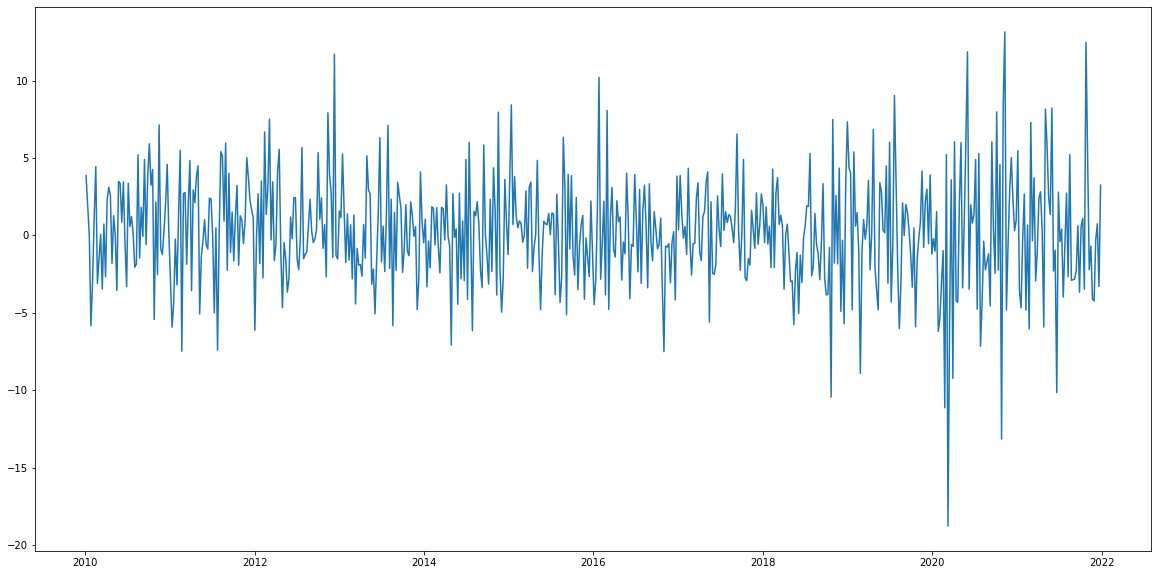

In [111]:
plt.figure(figsize=(20,10))
plt.plot(asset.ds,asset.y)
plt.show()

In [112]:
last_train_year = 2020 
test_year = 2021

train = asset[asset.ds.dt.year <= 2019]
test = asset[asset.ds.dt.year >= 2020]

print(train.shape,test.shape)

(522, 2) (104, 2)


In [113]:
model = Prophet(growth="flat",
                n_changepoints = 5,
                weekly_seasonality=True,
                daily_seasonality=True,
                yearly_seasonality=True)
model.add_country_holidays(country_name="Brazil")

model.fit(train)

In [114]:
future = model.make_future_dataframe(periods=1,freq='w')
forecast = model.predict(future)



df_prediction_train = pd.DataFrame(forecast[["ds","yhat"]].iloc[0:-1,:])
df_prediction_train.set_index("ds",inplace=True)
df_prediction_train

,yhat
ds,
2010-01-04,0.849029
2010-01-11,0.371237
2010-01-18,0.239242
2010-01-25,0.501073
2010-02-01,0.757876
...,...
2019-12-02,0.035858
2019-12-09,-0.067882
2019-12-16,0.421328


In [115]:
days = test.ds
dict_prediction_test = {}

for i in range(window,len(days)+window):
   
    window_returns = asset[i-window:i]
    
    future = model.make_future_dataframe(periods=i+1-window,freq="w")
    prediction = model.predict(future)
    dict_prediction_test[str(future.iloc[-1].values[0])] = prediction.yhat.iloc[-1]


df_prediction_test = pd.DataFrame(index=dict_prediction_test.keys(),data=dict_prediction_test.values())                            

df_prediction_test.index = pd.to_datetime(df_prediction_test.index)

df_prediction_test.rename(columns={0:"PETR4.SA"},inplace=True) 
df_prediction_test

,PETR4.SA
2020-01-05,0.814206
2020-01-12,0.347446
2020-01-19,0.249031
2020-01-26,0.526434
2020-02-02,0.765754
...,...
2021-11-28,0.286972
2021-12-05,-0.096369
2021-12-12,0.122862
2021-12-19,0.750302


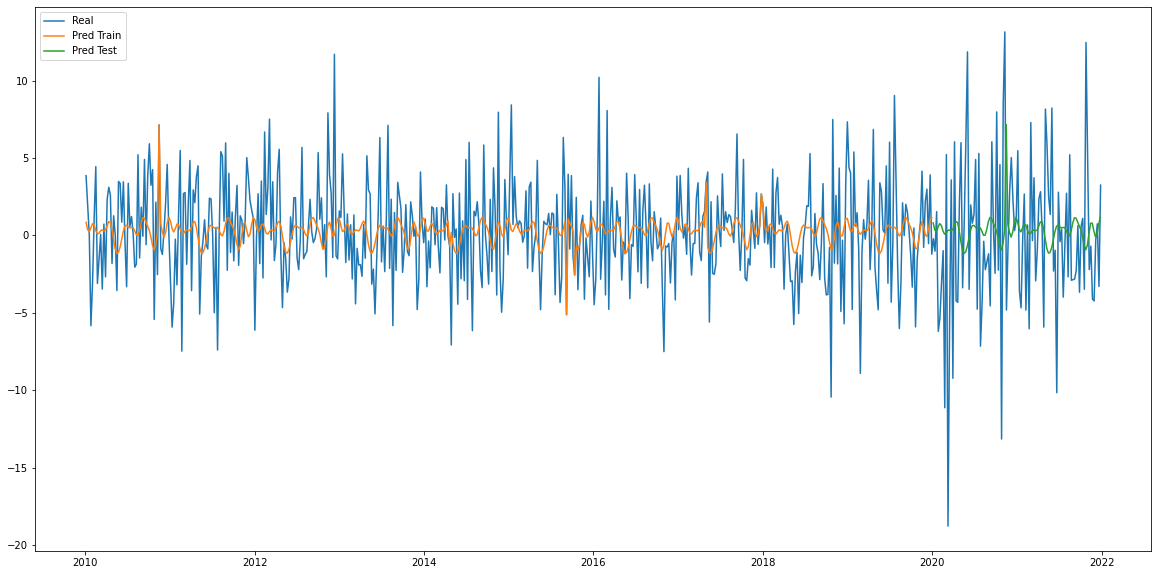

In [123]:
plt.figure(figsize=(20,10))
plt.plot(asset.ds,asset.y,label="Real")
plt.plot(df_prediction_train,label="Pred Train")
plt.plot(df_prediction_test,label="Pred Test")
plt.legend()
plt.show()

In [117]:
# #rolling window

# window = 12
# train = asset[asset.ds.dt.year <= 2019]
# test = asset[asset.ds.dt.year >= 2020]

# days = train.ds
# dict_prediction_train = {}

# for i in range(window,len(days)):
#     window_returns = asset[i-window:i]
#     model = Prophet(growth="flat",
#                     n_changepoints = window//2,
#                     weekly_seasonality=True,
#                     daily_seasonality=True,
#                     yearly_seasonality=True)
#     model.add_country_holidays(country_name="BR")
    
#     model.fit(window_returns)
    
#     future = model.make_future_dataframe(periods=1,freq="w")

#     prediction = model.predict(future)
#     # print(prediction.ds,prediction.yhat)
#     # print(str(future.values[window][0]),prediction.yhat[window])
#     # break
#     dict_prediction_train[str(future.values[window][0])] = prediction.yhat[window]/1 

# df_prediction_train = pd.DataFrame(index=dict_prediction_train.keys(),data=dict_prediction_train.values())                            

# df_prediction_train.index = pd.to_datetime(df_prediction_train.index)

# df_prediction_train.rename(columns={0:"PETR4.SA"},inplace=True) 


In [118]:
# plt.figure(figsize=(20,10))
# plt.plot(df_prediction_train,label="prediction")
# plt.plot(train.ds,train.y,label="train")
# plt.legend()
# plt.show()

In [119]:
# days = test.ds
# dict_prediction_test = {}

# for i in range(window,len(days)):
#     window_returns = asset[i-window:i]
#     model = Prophet(growth="flat",
#                     n_changepoints = window//2,
#                     weekly_seasonality=True,
#                     daily_seasonality=True,
#                     yearly_seasonality=True)
#     model.add_country_holidays(country_name="BR")
    
#     future = model.make_future_dataframe(periods=1,freq="w")

#     prediction = model.predict(future)
#     # print(prediction.ds,prediction.yhat)
#     # print(str(future.values[window][0]),prediction.yhat[window])
#     # break
#     dict_prediction_train[str(future.values[window][0])] = prediction.yhat[window]/1 

# df_prediction_train = pd.DataFrame(index=dict_prediction_train.keys(),data=dict_prediction_train.values())                            

# df_prediction_train.index = pd.to_datetime(df_prediction_train.index)

# df_prediction_train.rename(columns={0:"PETR4.SA"},inplace=True) 
